# Predicting Customer Churn
For an entreprise, retaining a customer is cheaper than finding a new one, thus having a better understanding on why people churn and what variables make them more likely to leave is vital for the success of a company

### Objective
The purpose of this project is to predict customer churn based on different explanatory variables such as consumed services and demographics.

### Performance
To do so, a classification model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* accuracy: % of good estimations 
* recall: % of positives outcomes correctly identified (TP / (TP+FN) )
* precision: % of positive predictions that are actually correct (TP / (TP+FP) )
* f1-score: harmonic mean of precision and recall

For this task, the most important is to identify as much customers likely to leave the company as possible, i.e. have a good recall. However, if all customers were identified like likely to leave, recall would be very high but precision would probably be very low as there would be many false positives. For this reason, it is important to get a high recall, but also a high precision (and therefore, a good f1-score). 

===================================================================================================

# Exploratory Data Analysis
===================================================================================================

# Import libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for the yeo-johnson transformation
import scipy.stats as stats

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# for plotting missing values
import missingno as msno

# for Splitting train/test sets
from sklearn.model_selection import train_test_split

# to display all the columns of the dataframe in the notebook & all float numbers rounded to 2digits
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Load & Split data

In [2]:
data_dict = raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 0)
raw_data = pd.read_excel('E Commerce Dataset.xlsx', sheet_name = 1)
raw_data.head(3)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.00,Mobile Phone,3,6.00,Debit Card,Female,3.00,3,Laptop & Accessory,2,Single,9,1,11.00,1.00,1.00,5.00,159.93
1,50002,1,NaN,Phone,1,8.00,UPI,Male,3.00,4,Mobile,3,Single,7,1,15.00,0.00,1.00,0.00,120.90
2,50003,1,NaN,Phone,1,30.00,Debit Card,Male,2.00,4,Mobile,3,Single,6,1,14.00,0.00,1.00,3.00,120.28


In [3]:
# Checking for duplicates
raw_data.duplicated().sum()

0

In [4]:
# Checking for transactional data, each row = one customer
raw_data.CustomerID.nunique() == len(raw_data)

True

In [5]:
# Since CustomerID does not provide any meaningful information, it's better to remove it
data = raw_data.drop(['CustomerID'], axis = 1)

In [6]:
# Splitting into train & test sets to avoid data leakage
train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42) 

In [7]:
print(f'The train set contains {train_set.shape[0]} rows and {train_set.shape[1]} columns.')
print(f'The test set contains {test_set.shape[0]} rows and {test_set.shape[1]} columns.')

The train set contains 4504 rows and 19 columns.
The test set contains 1126 rows and 19 columns.


===================================================================================================
# Analysis

In [8]:
df = train_set.copy()

# 1. Target

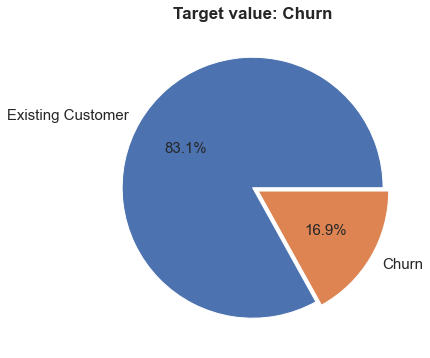

In [9]:
# pie-chart to evaluate target distribution (im/balance)

churn_rate = len(df[df.Churn == 1])/len(df)
perc_attrition = [1 - churn_rate, churn_rate]
labels = ['Existing Customer', 'Churn']
explode = (0, 0.05)

plt.figure(figsize = (8,6))
plt.title(r'Target value: Churn', weight = 'bold', size = 17) 
plt.pie(perc_attrition, explode = explode, labels = labels, autopct = '%1.1f%%', textprops = {'size':15})
plt.show()

As usual in these type of tasks, the data is imabalanced => Only ~17% of positive values.

To deal with class imbalance a few solutions:
* Undersampling the majority class (random under-sampling, tomek links under-sampling)
* Oversample the minority class (most popular technique: SMOTE --Synthetic Minority Oversampling Technique)

More at: *https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/*

# 2. Variable types (categorical, numerical)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4504 entries, 4478 to 860
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        4504 non-null   int64  
 1   Tenure                       4288 non-null   float64
 2   PreferredLoginDevice         4504 non-null   object 
 3   CityTier                     4504 non-null   int64  
 4   WarehouseToHome              4301 non-null   float64
 5   PreferredPaymentMode         4504 non-null   object 
 6   Gender                       4504 non-null   object 
 7   HourSpendOnApp               4298 non-null   float64
 8   NumberOfDeviceRegistered     4504 non-null   int64  
 9   PreferedOrderCat             4504 non-null   object 
 10  SatisfactionScore            4504 non-null   int64  
 11  MaritalStatus                4504 non-null   object 
 12  NumberOfAddress              4504 non-null   int64  
 13  Complain        

All variables seem to be numeric

### Categorical variables

In [11]:
# Identifying categorical variables
cat_vars = [var for var in df.columns if df[var].dtype == 'O']

print(f'There are {len(cat_vars)} categorical features:\n{cat_vars}')

There are 5 categorical features:
['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']


### Numerical variables

In [12]:
num_vars = [var for var in df.columns if df[var].dtype != 'O' and var !='Churn']
print(f'There are {len(num_vars)} numerical features:\n{num_vars}')

There are 13 numerical features:
['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


# 3. Missing data

In [13]:
# make a list of the variables that contain missing values
vars_with_nan = [var for var in df.columns if df[var].isnull().sum() > 0]

# % of missing values
df[vars_with_nan].isnull().sum().sort_values(ascending=False)

DaySinceLastOrder              230
Tenure                         216
OrderAmountHikeFromlastYear    216
OrderCount                     207
HourSpendOnApp                 206
WarehouseToHome                203
CouponUsed                     203
dtype: int64

All variable with missing values seem to contain numerical values and have around the same percentage of missing values. This could mean that the values are not missing at random, so further exploration must be applied

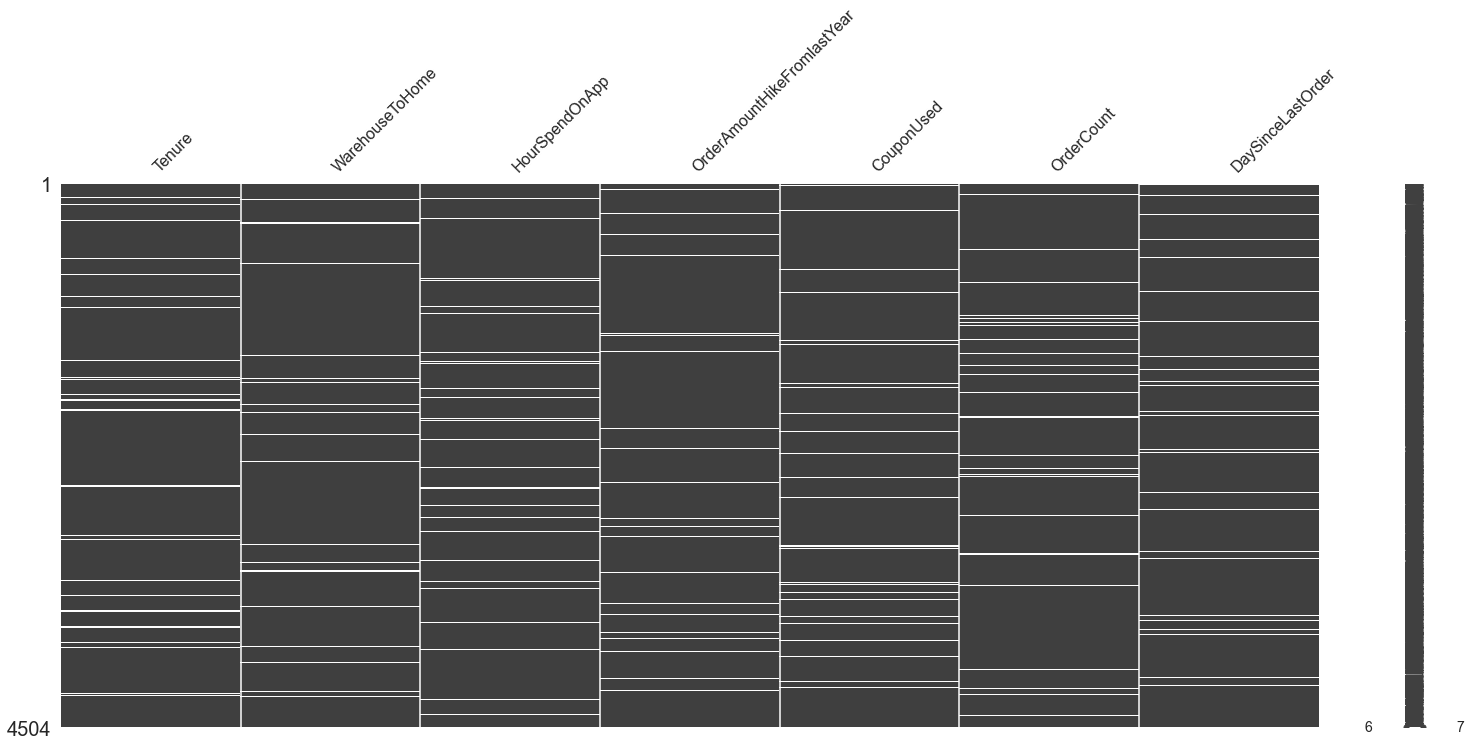

In [14]:
msno.matrix(df[vars_with_nan])
plt.show()

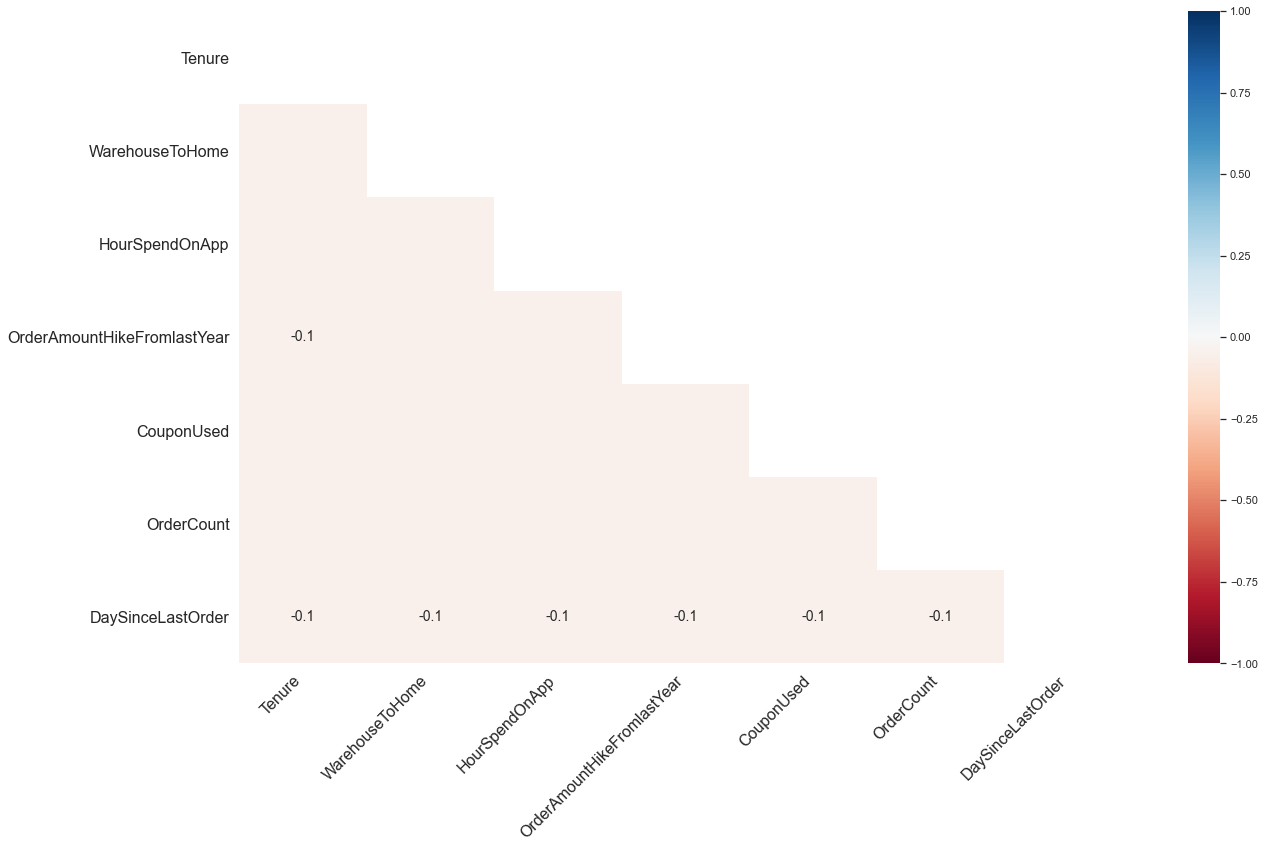

In [15]:
msno.heatmap(df)
plt.show()

In [16]:
# Checking if there are rows containing more than 1 missing value
df[df.isnull().sum(axis = 1) > 1].index

Int64Index([], dtype='int64')

In [17]:
# Showing rows containing at least one missing value
df[df.isna().any(axis=1)]

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
731,0,0.00,Phone,1,9.00,Debit Card,Male,NaN,4,Mobile,3,Single,2,0,12.00,0.00,1.00,2.00,130.33
291,0,NaN,Computer,1,8.00,Debit Card,Male,2.00,3,Mobile Phone,2,Divorced,2,1,23.00,1.00,1.00,0.00,117.02
533,0,17.00,Phone,1,NaN,Debit Card,Male,3.00,3,Mobile,5,Divorced,2,1,13.00,2.00,7.00,1.00,125.59
4981,0,23.00,Mobile Phone,3,15.00,Cash on Delivery,Male,3.00,5,Grocery,4,Married,8,0,18.00,2.00,NaN,4.00,256.20
2807,0,12.00,Mobile Phone,3,30.00,E wallet,Female,2.00,4,Grocery,1,Married,1,0,11.00,3.00,9.00,NaN,220.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,1,NaN,Phone,3,13.00,Debit Card,Male,3.00,3,Mobile,1,Married,2,1,21.00,1.00,1.00,2.00,122.75
474,0,NaN,Phone,2,19.00,UPI,Male,2.00,3,Mobile,4,Divorced,4,0,13.00,1.00,1.00,4.00,121.43
3385,1,1.00,Mobile Phone,3,7.00,Debit Card,Male,3.00,5,Fashion,3,Divorced,7,0,12.00,2.00,12.00,NaN,231.09
769,0,27.00,Mobile Phone,1,9.00,Debit Card,Male,2.00,3,Grocery,2,Divorced,4,0,14.00,NaN,1.00,9.00,277.79


Missing values seem to be missing at random, there does not seem to be a pattern behind and other features seem to play no role on the probability to get a missing value.

In [18]:
def analyse_na_value(data, var):
    df = data.copy()

    # let's make an interim variable that indicates 1 if the observation was missing --0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing vs the observations where data is available

    # determine the median price in the groups 1 and 0, and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)['Churn'].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Churn", color='green')

    plt.show()

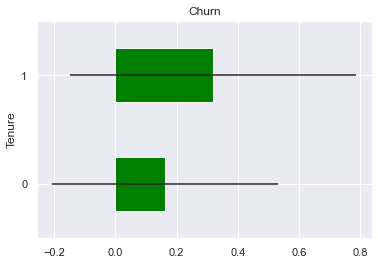

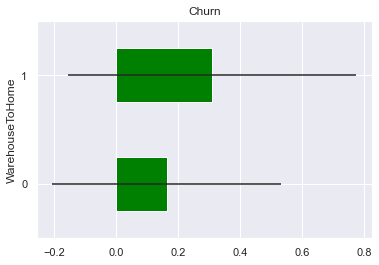

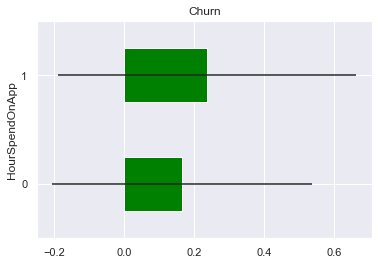

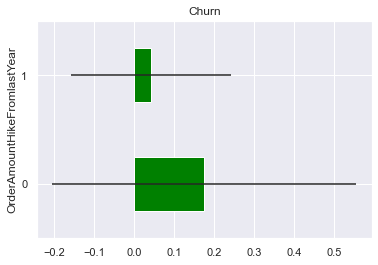

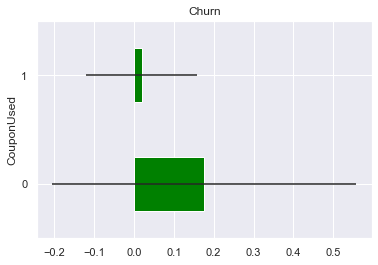

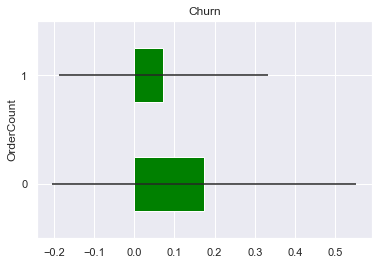

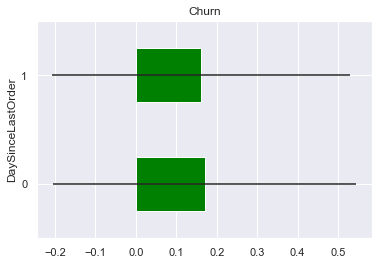

In [19]:
# Run the function on each variable with missing data
for var in vars_with_nan:
    analyse_na_value(df, var)

Although the confidence intervals overlap greatly, most variables seem to have a distinct difference in their mean churn values when there is missing data vs when where there is not.

# 4. Numerical variables

In [20]:
# Exploring the numerical variables
df[num_vars].head(3)

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
4478,1.00,1,12.00,3.00,4,4,3,1,13.00,1.00,2.00,3.00,149.78
3685,17.00,1,13.00,4.00,5,3,3,1,15.00,2.00,2.00,9.00,165.81
731,0.00,1,9.00,NaN,4,3,2,0,12.00,0.00,1.00,2.00,130.33


In [21]:
df.describe()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,4504.00,4288.00,4504.00,4301.00,4298.00,4504.00,4504.00,4504.00,4504.00,4288.00,4301.00,4297.00,4274.00,4504.00
mean,0.17,10.20,1.66,15.69,2.93,3.69,3.06,4.20,0.29,15.74,1.77,3.03,4.51,177.15
std,0.38,8.62,0.92,8.62,0.72,1.02,1.38,2.57,0.45,3.69,1.89,2.95,3.63,49.12
min,0.00,0.00,1.00,5.00,0.00,1.00,1.00,1.00,0.00,11.00,0.00,1.00,0.00,0.00
25%,0.00,2.00,1.00,9.00,2.00,3.00,2.00,2.00,0.00,13.00,1.00,1.00,2.00,145.70
50%,0.00,9.00,1.00,14.00,3.00,4.00,3.00,3.00,0.00,15.00,1.00,2.00,3.00,163.67
75%,0.00,16.00,3.00,21.00,3.00,4.00,4.00,6.00,1.00,18.00,2.00,3.00,7.00,195.82
max,1.00,61.00,3.00,127.00,5.00,6.00,5.00,22.00,1.00,26.00,16.00,16.00,46.00,324.99


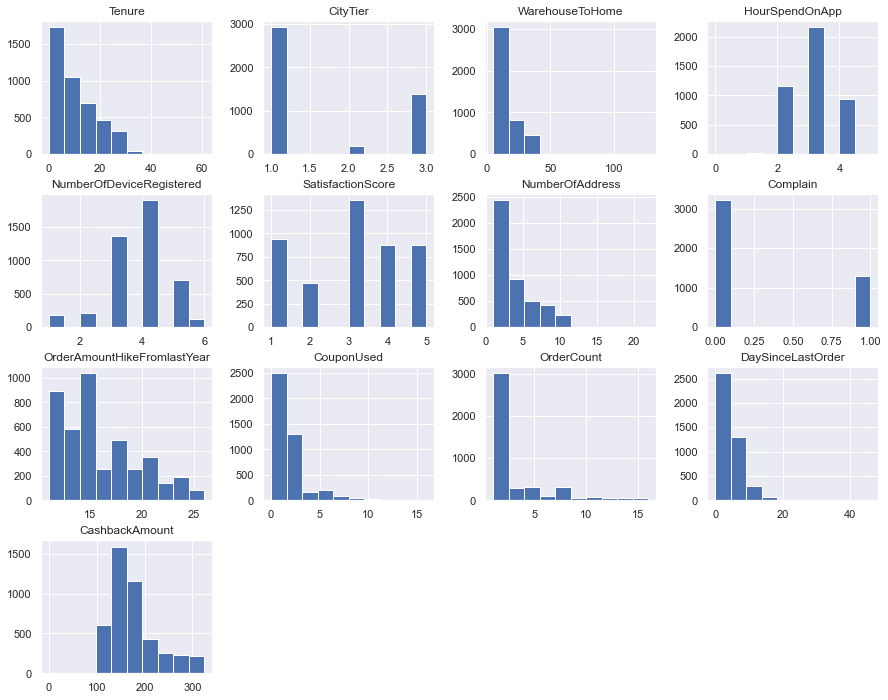

In [22]:
df[num_vars].hist(figsize = (15,12))
plt.show()

There are discrete and continuous variables. Moreover, most features do not follow a bell-shape curve distribution and a few are highly skewed.

## Continuous variables

### Yeo-Johnson transformation

In [23]:
# Continuous variables
cont_vars =  [var for var in num_vars if len(df[var].unique()) > 20]

# Applying log transformation
temp1 = df.copy()
for var in cont_vars:
    #transform the variable - yeo-johnson
    temp1[var], param = stats.yeojohnson(df[var])

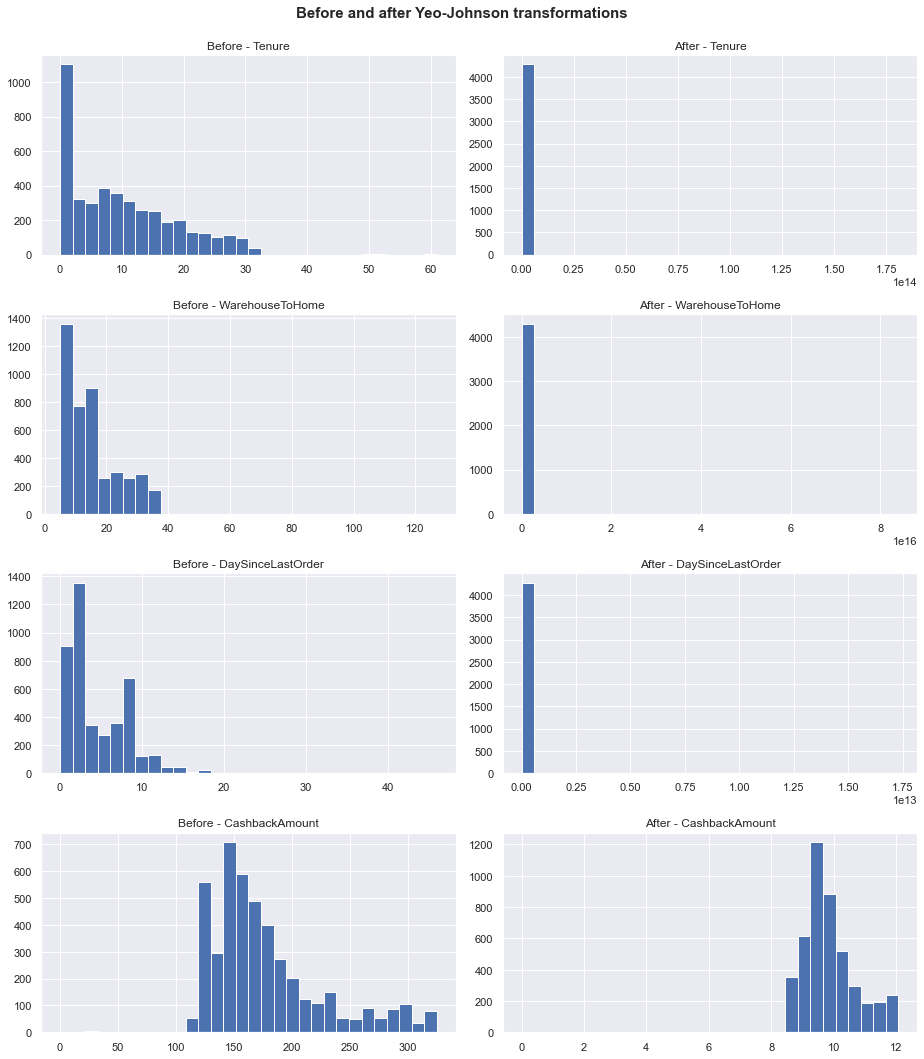

In [24]:
# Plotting new distributions
fig, axs = plt.subplots(len(cont_vars), 2, figsize = (13,15), tight_layout = True)
fig.suptitle('Before and after Yeo-Johnson transformations\n', weight = "bold", size = 15)   
for i, var in enumerate(cont_vars):
    # Before transformation
    axs[i,0].set_title(f'Before - {var}')
    axs[i,0].hist(df[var], bins = 30)
    
    # After transformation
    axs[i,1].set_title(f'After - {var}')
    axs[i,1].hist(temp1[var], bins = 30)
    
    continue
    
    plt.show()

No feature seem to profit from a Yeo-Johnson transformation.

### Log transformations

In [25]:
# Continuous strictly positive variables
log_vars = [var for var in cont_vars if df[var].isin([0]).sum() == 0]
log_vars

['WarehouseToHome']

In [26]:
# Applying log transformation
temp1 = df.copy()
for var in log_vars:
    #transform the variable - yeo-johnson
    temp1[var] = np.log(df[var])

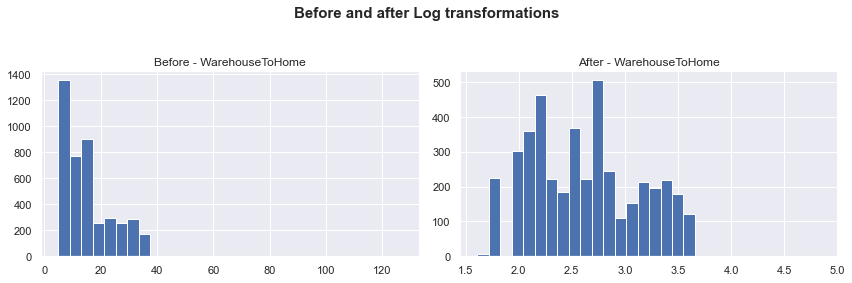

In [27]:
# Plotting new distributions
fig, axs = plt.subplots(len(log_vars), 2, figsize = (12,4), tight_layout = True)
fig.suptitle('Before and after Log transformations\n', weight = "bold", size = 15)   
for var in log_vars:
    # Before transformation
    axs[0].set_title(f'Before - {var}')
    axs[0].hist(df[var], bins = 30)
    
    # After transformation
    axs[1].set_title(f'After - {var}')
    axs[1].hist(temp1[var], bins = 30)
    
    continue
    
    plt.show()

The WarehouseToHome seem to have a slightly better spread after a log transformation. But the problem seem to be the presence of possible outliers.

In [28]:
df[df.WarehouseToHome > 40]

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
1309,0,25.00,Computer,3,126.00,Debit Card,Male,2.00,3,Mobile,1,Married,3,0,15.00,1.00,1.00,0.00,134.82
4124,0,26.00,Computer,3,127.00,Debit Card,Male,3.00,4,Mobile Phone,1,Married,4,0,16.00,2.00,2.00,1.00,159.82


correlation:  0.07955866630432683


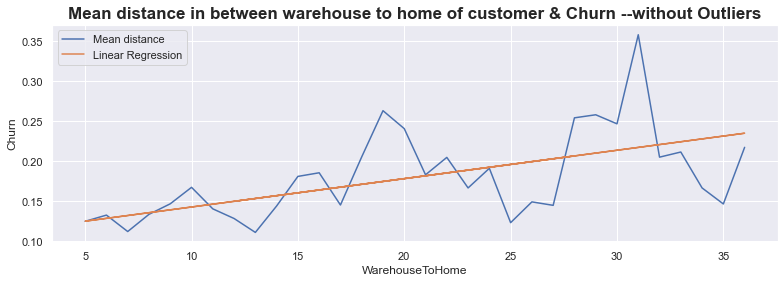

In [29]:
# Temporarly emoving the two outliers
temp = df[df.WarehouseToHome < 40]

# Plotting relationship with Churn
plt.figure(figsize = (13,4))
plt.title('Mean distance in between warehouse to home of customer & Churn --without Outliers', weight = 'bold', size = 17)
temp.groupby('WarehouseToHome')['Churn'].mean().plot(label = 'Mean distance')
print('correlation: ', temp.Churn.corr(temp['WarehouseToHome']))
plt.ylabel('Churn')
plt.yticks(np.arange(0,0.5,0.05))

# adding linear regression line
y = temp.Churn
x = temp.WarehouseToHome
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, label = 'Linear Regression')
plt.legend()
plt.show()

correlation:  0.07380195215707215


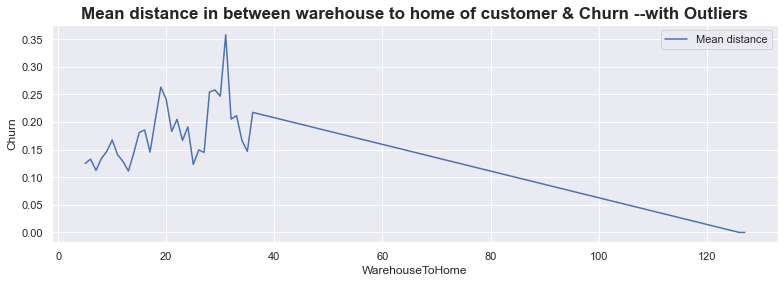

In [30]:
# Plotting relationship with Churn when outliers are not excluded
plt.figure(figsize = (13,4))
plt.title('Mean distance in between warehouse to home of customer & Churn --with Outliers', weight = 'bold', size = 17)
df.groupby('WarehouseToHome')['Churn'].mean().plot(label = 'Mean distance')
print('correlation: ', df.Churn.corr(df['WarehouseToHome']))
plt.ylabel('Churn')
plt.yticks(np.arange(0,0.4,0.05))
plt.legend()
plt.show()

It seems that there are two outliers in the WarehouseToHome feature that could hurt the model performance as they do not align with the positive correlation that is expected and seems to exist between the feature and Churn. Moreover, we can see that the correlation between the distance and the target value is stronger without these two outliers. 

Therefore, it could be interesting to treat these two outliers like not representative and therefore either remove them or to apply winsorization, i.e. to transform them to be closer to the mean distribution. To avoid losing data, the second option seems more appropriate for this case.

### Exploring continuous variables relationship with Churn

correlation with churn rate:  -0.3510995581436457


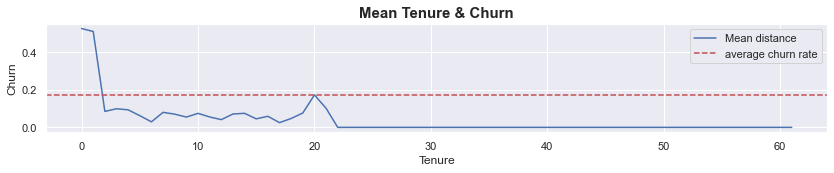

correlation with churn rate:  -0.1621383065863703


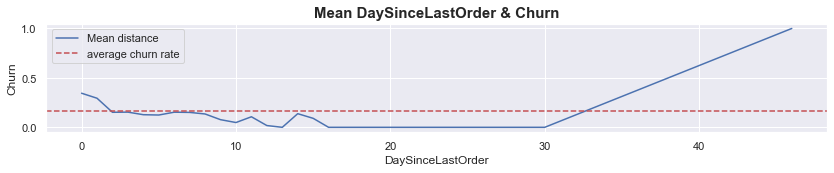

correlation with churn rate:  -0.16686063125866035


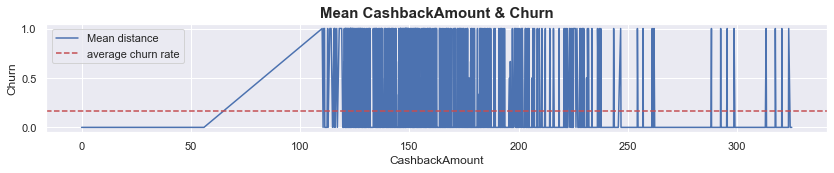

In [31]:
for var in cont_vars:
    if var != 'WarehouseToHome':
        plt.figure(figsize = (14,2))
        plt.title(f'Mean {var} & Churn', weight = 'bold', size = 15)
        df.groupby(f'{var}')['Churn'].mean().plot(label = 'Mean distance')
        print('correlation with churn rate: ', df.Churn.corr(df[f'{var}']))
        plt.axhline(y = df.Churn.mean(), color = 'r', linestyle = '--', label = 'average churn rate')
        plt.ylabel('Churn')

        plt.legend()
        plt.show()

It seems that:
* When tenure is low, churn is higher
* When days since last order increases, churn rate increases too, although there seems to have a negative correlation. This leads to believe that there are outliers.
* There is an unclear relationship between the Average cashback in last month and churn, although there seems to have a negative correlation

In [32]:
df[df.DaySinceLastOrder > 30]

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
2040,1,0.00,Mobile Phone,3,6.00,Debit Card,Male,2.00,4,Fashion,3,Married,6,0,11.00,5.00,11.00,46.00,206.09


Indeed, there is one outlier that seems to change the shape of the relationship. However, it is possible that the relationship between the feature, DaySinceLastOrder, and the average churn rate changes up to a certain threshold. 

More precisely, it does not seem unexpected that a customer that does not have bought anything in more than a month ends up leaving the company, so in this case, it is probably better to leave the outlier.

## Discrete variables

In [33]:
disc_vars = [var for var in num_vars if var not in cont_vars and var != 'Churn']
df[disc_vars].head(3)

,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount
4478,1,3.00,4,4,3,1,13.00,1.00,2.00
3685,1,4.00,5,3,3,1,15.00,2.00,2.00
731,1,NaN,4,3,2,0,12.00,0.00,1.00


In [34]:
df[disc_vars].describe()

,CityTier,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount
count,4504.00,4298.00,4504.00,4504.00,4504.00,4504.00,4288.00,4301.00,4297.00
mean,1.66,2.93,3.69,3.06,4.20,0.29,15.74,1.77,3.03
std,0.92,0.72,1.02,1.38,2.57,0.45,3.69,1.89,2.95
min,1.00,0.00,1.00,1.00,1.00,0.00,11.00,0.00,1.00
25%,1.00,2.00,3.00,2.00,2.00,0.00,13.00,1.00,1.00
50%,1.00,3.00,4.00,3.00,3.00,0.00,15.00,1.00,2.00
75%,3.00,3.00,4.00,4.00,6.00,1.00,18.00,2.00,3.00
max,3.00,5.00,6.00,5.00,22.00,1.00,26.00,16.00,16.00


In [35]:
def relationship_with_churn(var, corr = 'spearman', x_rotation = 0):
    plt.figure(figsize = (8,4))
    df.groupby(f'{var}')['Churn'].mean().plot.bar()
    print('---------------------------------')
    print(f'{var} {corr} correlation with churn rate: ', round(df.Churn.corr(df[f'{var}'], method = corr),3))
    plt.axhline(y = df.Churn.mean(), color = 'r', linestyle = '--', label = 'total average churn rate')
    plt.title(f'Average churn for "{var}" different values', weight = 'bold', size = 13)
    plt.ylabel('Churn')
    plt.xticks(rotation = x_rotation)
    plt.xlabel('')
    plt.legend()
    plt.show()

---------------------------------
CityTier spearman correlation with churn rate:  0.086


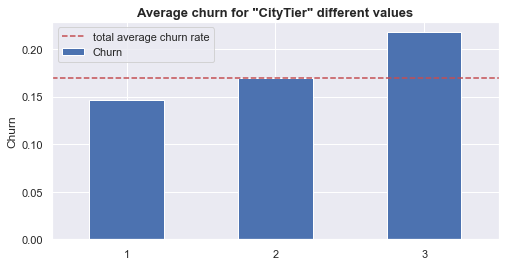

---------------------------------
HourSpendOnApp spearman correlation with churn rate:  0.01


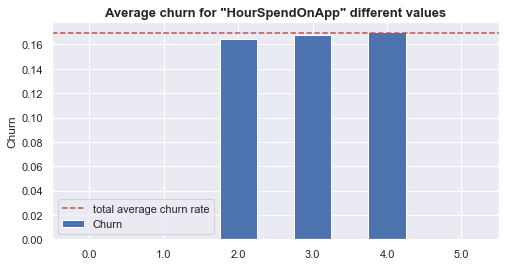

---------------------------------
NumberOfDeviceRegistered spearman correlation with churn rate:  0.098


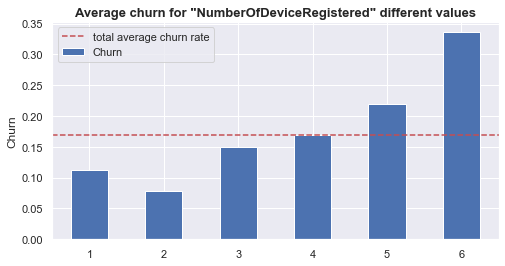

---------------------------------
SatisfactionScore spearman correlation with churn rate:  0.101


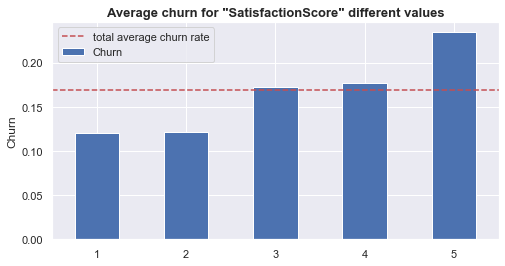

---------------------------------
NumberOfAddress spearman correlation with churn rate:  0.023


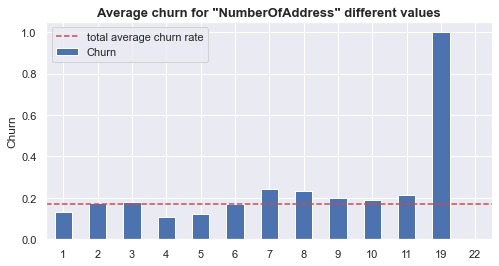

---------------------------------
Complain spearman correlation with churn rate:  0.247


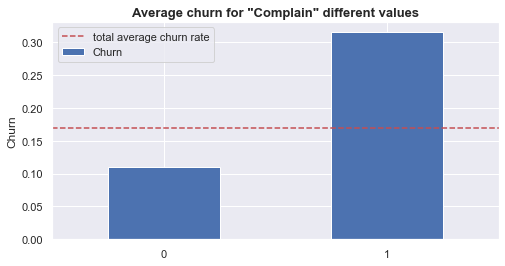

---------------------------------
OrderAmountHikeFromlastYear spearman correlation with churn rate:  -0.012


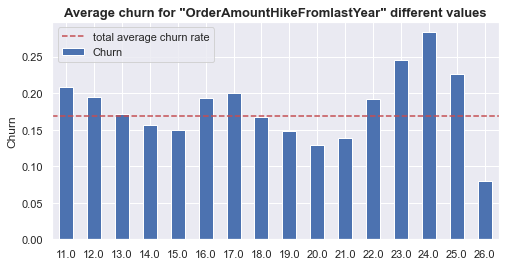

---------------------------------
CouponUsed spearman correlation with churn rate:  -0.016


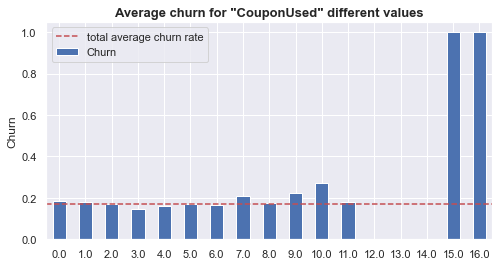

---------------------------------
OrderCount spearman correlation with churn rate:  -0.036


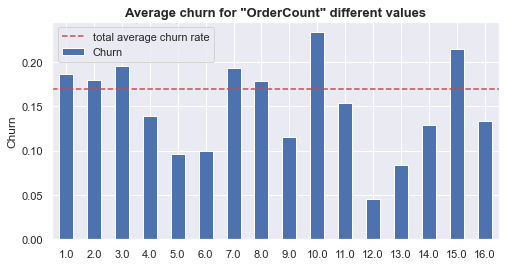

In [36]:
# Exploring the contribution of discrete variables to the churn rate
for var in disc_vars:
    relationship_with_churn(var)

As expected, people who have complains seem more likely to churn. Surprisingly, however, it seems that a higher satisfaction score seem to lead to higher churn rates. 

# Categorical Variables

In [37]:
print('Number of categorical variables: ', len(cat_vars))
df[cat_vars].head()

Number of categorical variables:  5


,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
4478,Mobile Phone,Debit Card,Female,Mobile Phone,Single
3685,Mobile Phone,Credit Card,Female,Laptop & Accessory,Single
731,Phone,Debit Card,Male,Mobile,Single
291,Computer,Debit Card,Male,Mobile Phone,Divorced
184,Phone,COD,Male,Mobile Phone,Divorced


In [38]:
df.describe(include='O')

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,4504,4504,4504,4504,4504
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2209,1845,2738,1644,2396


## Cardinality

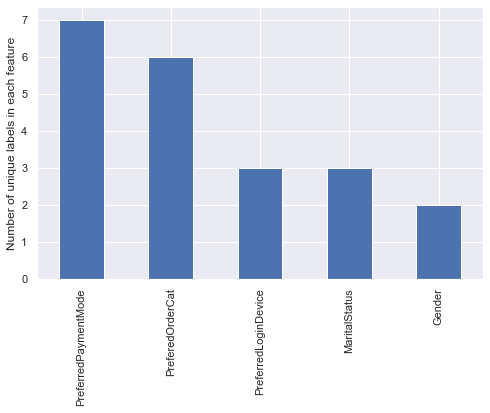

In [39]:
# Counting number of unique categories per feature, in descending order
df[cat_vars].nunique().sort_values(ascending = False).plot.bar(figsize = (8,5))
plt.ylabel('Number of unique labels in each feature')
plt.show()

In [40]:
def vis_cardinality(var):
    fig, ax = plt.subplots()
    data = df[f'{var}'].value_counts()
    plt.pie(data, labels = data.index, autopct = '%1.1f%%', textprops = {'size':13})
    plt.title(f'{var}', weight = 'bold', size = 15) 
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
#           ncol=3, fancybox=True, shadow=True)
    plt.show()
    print('-----------------------------------------------------')

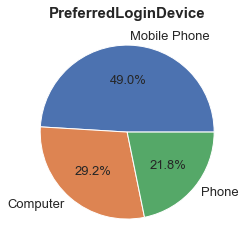

-----------------------------------------------------


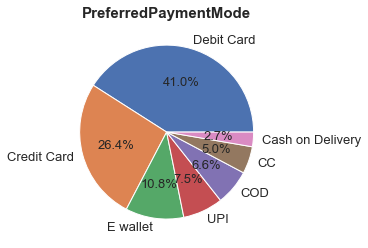

-----------------------------------------------------


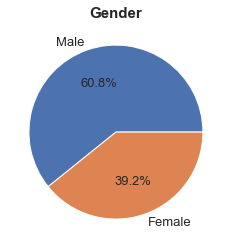

-----------------------------------------------------


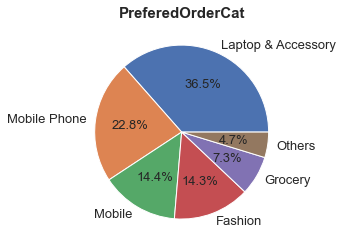

-----------------------------------------------------


In [41]:
for var in cat_vars[:-1]:
    vis_cardinality(var)

There are some variables that have only two categories and can be simply one-hot encoded, others need more consideration, especially since there is a risk of high correlation between "Internet Service : No" and all other features that translate the same information.

---------------------------------
PreferredLoginDevice spearman correlation with churn rate:  0.01


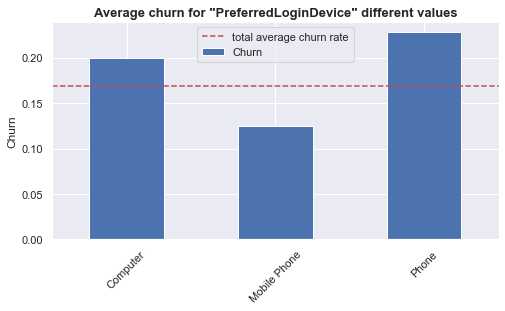

---------------------------------
PreferredPaymentMode spearman correlation with churn rate:  -0.002


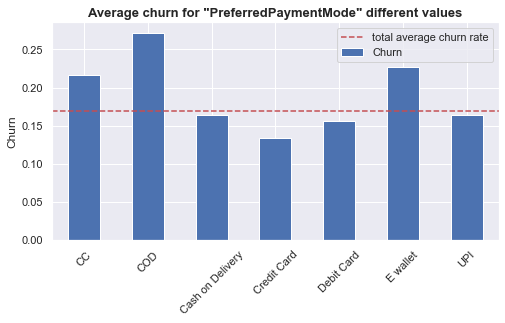

---------------------------------
Gender spearman correlation with churn rate:  0.034


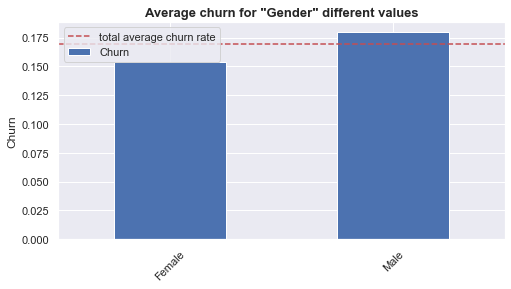

---------------------------------
PreferedOrderCat spearman correlation with churn rate:  0.139


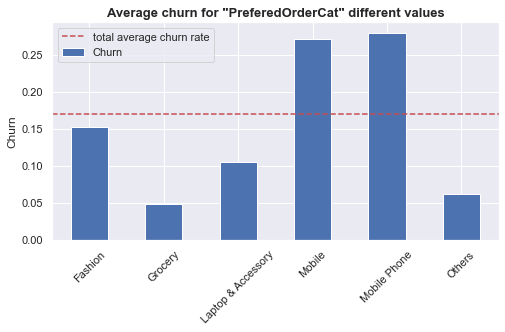

---------------------------------
MaritalStatus spearman correlation with churn rate:  0.156


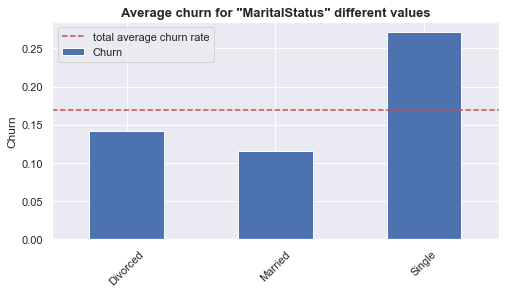

In [42]:
# Exploring the contribution of discrete variables to the churn rate
for var in cat_vars:
    relationship_with_churn(var, x_rotation = 45)

Most features classes seem to have a weak relationship with the average churn rate. 